In [1]:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd, gluon
mx.random.seed(1)



In [2]:
# to develop good habits we’re going to specify two contexts: one for data and one for our models.
data_ctx = mx.cpu()
model_ctx = mx.cpu()

In [5]:
# squared loss heavily penalizes outlier

In [3]:
num_inputs = 2
num_outputs = 1
num_examples = 10000

def real_fn(X):
    return 2 * X[:, 0] - 3.14 * X[:, 1] + 4.2

X = nd.random_normal(shape=(num_examples, num_inputs), ctx=data_ctx)
noise = .1 * nd.random_normal(shape=(num_examples,), ctx=data_ctx)
y = real_fn(X) + noise

In [5]:
X[0:10], y[0:10]

(
 [[-0.6776515   0.10073948]
  [ 0.5759544  -0.3469252 ]
  [-0.22134334 -1.804719  ]
  [-0.8064291   1.220331  ]
  [ 2.2323563   0.2007023 ]
  [-0.5496865  -0.19819015]
  [-0.38577855  1.37109   ]
  [-0.23789984  0.14867957]
  [-0.49851316 -0.84815776]
  [ 0.07811152 -0.38241303]]
 <NDArray 10x2 @cpu(0)>, 
 [ 2.4712923  6.3371096  9.325349  -1.2196102  7.815972   3.7245889
  -1.0323958  3.4061756  5.8446126  5.378854 ]
 <NDArray 10 @cpu(0)>)

In [6]:
2 * X[0, 0] - 3.14 * X[0, 1] + 4.2


[2.5283747]
<NDArray 1 @cpu(0)>

In [20]:
# data iterator
import random
batch_size = 10
def data_iter():
    idx = list(range(num_examples))
    random.shuffle(idx)
    for i in range(0, num_examples, batch_size):
        j = nd.array(idx[i:min(i+batch_size, num_examples)])
        print('i={}, j={}'.format(i, j))
        yield nd.take(X, j), nd.take(y, j)

In [27]:
list(range(0, 99, 10))

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

In [25]:
[1, 2, 3][0:2]

[1, 2]

In [26]:
for data, label in data_iter():
    print(data, label)
    break

i=0, j=
[1218. 7163.  941. 8438. 8507. 3084.  824. 8154. 1159.  788.]
<NDArray 10 @cpu(0)>

[[ 0.5785104   0.2286292 ]
 [ 2.2462327   0.72192544]
 [ 0.5945264   1.0602204 ]
 [ 1.9948853   0.30794683]
 [-0.78911614  1.5559764 ]
 [ 0.58920074 -0.61008435]
 [ 0.762595   -0.09649518]
 [-0.84279716 -1.7937375 ]
 [-0.60733134 -0.21975182]
 [ 0.37882772  0.3774869 ]]
<NDArray 10x2 @cpu(0)> 
[ 4.6599813  6.4588723  1.9763579  7.3047533 -2.3197906  7.274734
  5.9469037  8.171145   3.8353803  3.8471246]
<NDArray 10 @cpu(0)>


In [13]:
nd.take?

In [16]:
range?

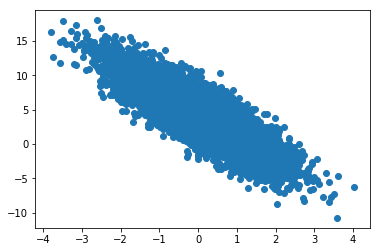

In [10]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 1].asnumpy(), y.asnumpy())

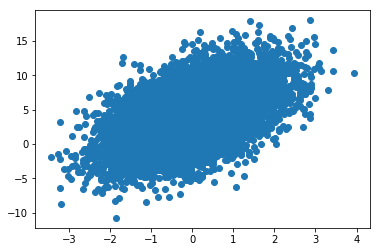

In [11]:
plt.scatter(X[:, 0].asnumpy(), y.asnumpy())

In [15]:
X[:,0]


[-0.6776515   0.5759544  -0.22134334 ...  0.2741112   0.31399575
  1.278037  ]
<NDArray 10000 @cpu(0)>

In [37]:
batch_size = 4
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X, y),
                                   batch_size=batch_size,
                                   shuffle=True)

In [31]:
for i, (data, label) in enumerate(train_data):
    print(data, label)
    break
# If we run that same code again you’ll notice that we get a different batch. That’s because we instructed the DataLoader that shuffle=True


[[ 1.3217605  -0.78171635]
 [ 0.16290933 -1.2468204 ]
 [ 1.0231252  -0.99453187]
 [-0.01582958  2.8665667 ]]
<NDArray 4x2 @cpu(0)> 
[ 9.326202   8.490918   9.349664  -4.7893715]
<NDArray 4 @cpu(0)>


In [29]:
W = nd.random_normal(shape=(num_inputs, num_outputs), ctx=model_ctx)
b = nd.random_normal(shape=num_outputs, ctx=model_ctx)
params = [W, b]

In [30]:
W.shape, b.shape

((2, 1), (1,))

In [31]:
W



[[0.29108   ]
 [0.74489146]]
<NDArray 2x1 @cpu(0)>

In [32]:
# Attach a gradient buffer to this NDArray
for param in params:
    param.attach_grad()

In [33]:
def net(X):
    return nd.dot(X, W) + b

In [34]:
def square_loss(y_pred, y_true):
    return nd.mean((y_pred - y_true.reshape(y_pred.shape)) ** 2)

In [44]:
def SGD(params, lr):
    for param in params:
        print(param)
        param[:] = param - lr * param.grad

In [45]:
epochs = 10
lr = .001
num_batches = num_examples / batch_size

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx).reshape((-1, 1))
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, lr)
        cumulative_loss += loss.asscalar()
    print('Epoch %d, average loss: %f' % (e, cumulative_loss / num_batches))



[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)


[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)


[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)


[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)


[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)


[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)


[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 


[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 2x1 @cpu(0)>

[nan]
<NDArray 1 @cpu(0)>

[[nan]
 [nan]]
<NDArray 

In [40]:
W, b

(
 [[ 1.9908814]
  [-3.122895 ]]
 <NDArray 2x1 @cpu(0)>, 
 [4.181167]
 <NDArray 1 @cpu(0)>)

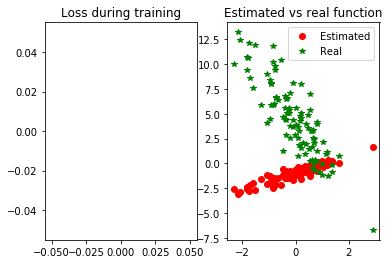

Epoch 0, batch 2499. Mean loss: 29.88341193115115
Epoch 1, batch 2499. Mean loss: 11.210607086551189
Epoch 2, batch 2499. Mean loss: 4.209655700574816
Epoch 3, batch 2499. Mean loss: 1.5846384000629186
Epoch 4, batch 2499. Mean loss: 0.6003973588045687
Epoch 5, batch 2499. Mean loss: 0.23127678855527192
Epoch 6, batch 2499. Mean loss: 0.09283234952641652
Epoch 7, batch 2499. Mean loss: 0.04089013742790557
Epoch 8, batch 2499. Mean loss: 0.021397377520031294
Epoch 9, batch 2499. Mean loss: 0.014085270603047683


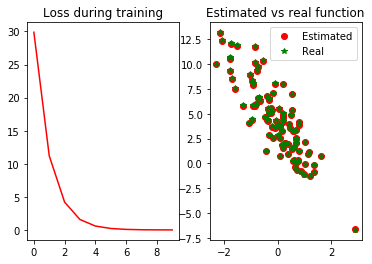

In [58]:
############################################
#    Re-initialize parameters because they
#    were already trained in the first loop
############################################
W[:] = nd.random_normal(shape=(num_inputs, num_outputs), ctx=model_ctx)
b[:] = nd.random_normal(shape=num_outputs, ctx=model_ctx)

############################################
#    Script to plot the losses over time
############################################
def plot(losses, X, sample_size=100):
    xs = list(range(len(losses)))
    f, (fg1, fg2) = plt.subplots(1, 2)
    fg1.set_title('Loss during training')
    fg1.plot(xs, losses, '-r')
    fg2.set_title('Estimated vs real function')
    fg2.plot(X[:sample_size, 1].asnumpy(),
             net(X[:sample_size, :]).asnumpy(), 'or', label='Estimated')
    fg2.plot(X[:sample_size, 1].asnumpy(),
             real_fn(X[:sample_size, :]).asnumpy(), '*g', label='Real')
    fg2.legend()

    plt.show()

learning_rate = .0001
losses = []
plot(losses, X)

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx).reshape((-1, 1))
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, lr)
        cumulative_loss += loss.asscalar()

    print("Epoch %s, batch %s. Mean loss: %s" % (e, i, cumulative_loss/num_batches))
    losses.append(cumulative_loss/num_batches)

plot(losses, X)